In [ ]:
!pip install -U keras-nlp

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import keras_nlp

Using TensorFlow backend


In [ ]:
!nvidia-smi --query-gpu=memory.total --format=csv,noheader
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [
        tf.config.LogicalDeviceConfiguration(memory_limit=15360 // 2),
        tf.config.LogicalDeviceConfiguration(memory_limit=15360 // 2),
    ],
)

logical_devices = tf.config.list_logical_devices("GPU")
logical_devices


PRETRAINING_BATCH_SIZE = 128

15360 MiB


In [ ]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications import efficientnet
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
IMAGES_PATH = "Flicker8k_Dataset"


IMAGE_SIZE = (225, 225)


VOCAB_SIZE = 10000


SEQ_LENGTH = 25


EMBED_DIM = 512


FF_DIM = 51
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
s = "1000268201_693b08cb0e.jpg#0"
s=s.split("#")[0]
s.strip()

'1000268201_693b08cb0e.jpg'

In [ ]:
img_name = os.path.join(IMAGES_PATH, s.strip())
print(img_name)

Flicker8k_Dataset/1000268201_693b08cb0e.jpg


In [ ]:
def load_captions_data(filename):
  with open(filename) as caption_file:
    caption_data = caption_file.readlines()
    caption_mapping ={}
    text_data=[]
    images_to_skip=set()

    for line in caption_data:
      line = line.rstrip("\n")
      img_name, caption = line.split("\t")

      img_name = img_name.split("#")[0]
      img_name = os.path.join(IMAGES_PATH, img_name.strip())

      tokens = caption.strip().split()

      if len(tokens) <5 or len(tokens) >SEQ_LENGTH:
        images_to_skip.add(img_name)
        continue

      if img_name.endswith("jpg") and img_name not in images_to_skip:
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        if img_name in caption_mapping:
            caption_mapping[img_name].append(caption)
        else:
            caption_mapping[img_name] = [caption]


    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del caption_mapping[img_name]

    return caption_mapping, text_data

def train_val_split(caption_data, train_ratio=0.8, shuffle=True):

  all_images = list(caption_data.keys())

  if shuffle:
    np.random.shuffle(all_images)

  train_size = int(len(caption_data)*train_ratio)

  training_data = {img_name:caption_data[img_name] for img_name in all_images[:train_size]}

  validation_data = {img_name: caption_data[img_name] for img_name in all_images[train_size:]}

  return training_data, validation_data


captions_mapping, text_data = load_captions_data("/content/Flickr8k.token.txt")







In [ ]:
train_data, val_data = train_val_split(captions_mapping)

In [ ]:
print(len(train_data), len(val_data))

6114 1529


In [ ]:
train_data

{'Flicker8k_Dataset/820169182_f5e78d7d19.jpg': ['<start> Two babies look up while they are playing in a playpen with a lot of balls . <end>',
  '<start> Two boys in tent-like area , with colorful balls on floor . <end>',
  '<start> Two children look up . <end>',
  '<start> Two kids are in a pen playing with colorful balls . <end>',
  '<start> Two young children play with colored balls . <end>'],
 'Flicker8k_Dataset/778885185_3f6905370b.jpg': ['<start> A brown dog chases a tattered ball around the yard . <end>',
  '<start> A brown dog is chasing a tattered soccer ball across a low cut field . <end>',
  '<start> Large brown dog playing with a white soccer ball in the grass . <end>',
  '<start> Tan dog chasing a ball . <end>',
  '<start> The tan dog is chasing a ball . <end>'],
 'Flicker8k_Dataset/2673564214_3a9598804f.jpg': ['<start> A young boy poses behind the netting of an enclosed play area while three other children play . <end>',
  '<start> Children playing in a green and blue boun

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
def decode_and_resize(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SIZE)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def process_input(img_path, captions):
  return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
  dataset = tf.data.Dataset.from_tensor_slices((images,captions))
  dataset = dataset.shuffle(BATCH_SIZE*8)
  dataset = dataset.map(process_input,num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

  return dataset

train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
val_dataset = make_dataset(list(val_data.keys()), list(val_data.values()))


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 25), dtype=tf.int64, name=None))>

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )

    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)


        img_embed = self.cnn_model(batch_img)


        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )


                batch_loss += loss
                batch_acc += acc


            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )


            grads = tape.gradient(loss, train_vars)


            self.optimizer.apply_gradients(zip(grads, train_vars))


        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)


        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0


        img_embed = self.cnn_model(batch_img)


        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )


            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        #
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):

        return [self.loss_tracker, self.acc_tracker]




In [ ]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, post_warmup_learning_rate, warmup_steps):
    super().__init__()
    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps

  def __call__(self,step):
    global_step =tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step / warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress

    return tf.cond(
        global_step < warmup_steps,
        lambda: warmup_learning_rate,
        lambda: self.post_warmup_learning_rate,
    )





In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of devices: 2


In [ ]:
with strategy.scope():
  cnn_model = get_cnn_model()
  encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
  decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
  caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
  )
  num_train_steps = len(train_dataset) * EPOCHS
  num_warmup_steps = num_train_steps // 15
  lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)
  caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

  caption_model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=val_dataset,
                  callbacks=[early_stopping])

Epoch 1/30
96/96 [==============================] - 156s 953ms/step - loss: 28.1556 - acc: 0.1300 - val_loss: 20.5365 - val_acc: 0.3096
Epoch 2/30
96/96 [==============================] - 64s 661ms/step - loss: 19.5410 - acc: 0.3127 - val_loss: 18.1247 - val_acc: 0.3483
Epoch 3/30
96/96 [==============================] - 63s 655ms/step - loss: 17.6805 - acc: 0.3470 - val_loss: 16.9962 - val_acc: 0.3690
Epoch 4/30
96/96 [==============================] - 60s 620ms/step - loss: 16.5836 - acc: 0.3663 - val_loss: 16.3879 - val_acc: 0.3806
Epoch 5/30
96/96 [==============================] - 60s 624ms/step - loss: 15.7976 - acc: 0.3815 - val_loss: 15.8667 - val_acc: 0.3901
Epoch 6/30
96/96 [==============================] - 63s 654ms/step - loss: 15.1831 - acc: 0.3924 - val_loss: 15.5825 - val_acc: 0.3958
Epoch 7/30
96/96 [==============================] - 60s 625ms/step - loss: 14.6671 - acc: 0.4021 - val_loss: 15.4134 - val_acc: 0.4008
Epoch 8/30
96/96 [==============================] - 59

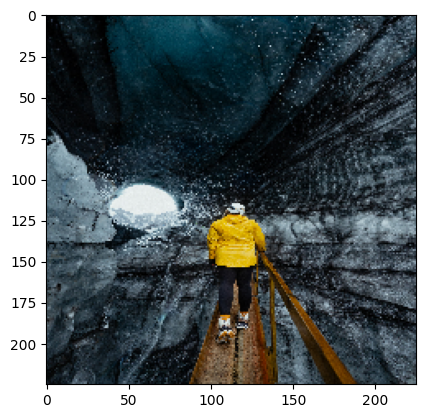

Predicted Caption:  a person in a yellow jacket is standing in the snow


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(val_data.keys())
from pathlib import Path

def generate_caption():
    sample_img = "/content/karsten-winegeart-VPMV6X5OACQ-unsplash.jpg"


    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()


    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)


    encoded_img = caption_model.encoder(img, training=False)


    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)



generate_caption()